In [ ]:
%%shell
jupyter nbconvert --to html

In [1]:
#Installing required libraries
!pip install -q pandas numpy matplotlib seaborn scipy openpyxl

In [2]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# **Arrivals**

In [ ]:
#Arrivals
arrivals = pd.read_csv('https://raw.githubusercontent.com/anjali-jv/Hospital-Wait-Times-Simulation/refs/heads/main/Data_Arrivals.csv')
arrivals.head()


,Unnamed: 0,1am,2am,3am,4am,5am,6am,7am,8am,9am,...,3pm,4pm,5pm,6pm,7pm,8pm,9pm,10pm,11pm,12am
0,Day1,0,0,2,1,0,0,0,2,1,...,3,2,1,7,4,5,2,3,4,2
1,Day2,3,2,1,0,0,0,0,0,3,...,3,4,6,6,2,2,3,2,3,3
2,Day3,1,0,2,1,0,1,1,2,3,...,4,5,8,7,4,3,1,2,2,4
3,Day4,1,0,0,1,0,2,0,5,2,...,4,2,3,8,4,8,3,3,3,5
4,Day5,1,2,0,1,1,1,2,1,1,...,8,2,10,5,6,2,3,3,4,3


# **Arrivals Data**

First 5 rows of the reshaped arrivals_long DataFrame:
    Day Hour  Arrival_Count
0  Day1  1am              0
1  Day2  1am              3
2  Day3  1am              1
3  Day4  1am              1
4  Day5  1am              1
Overall Arrival Distribution Statistics:
  Mean: 2.98 arrivals per hour
  Median: 2.00 arrivals per hour
  Standard Deviation: 2.45 arrivals per hour


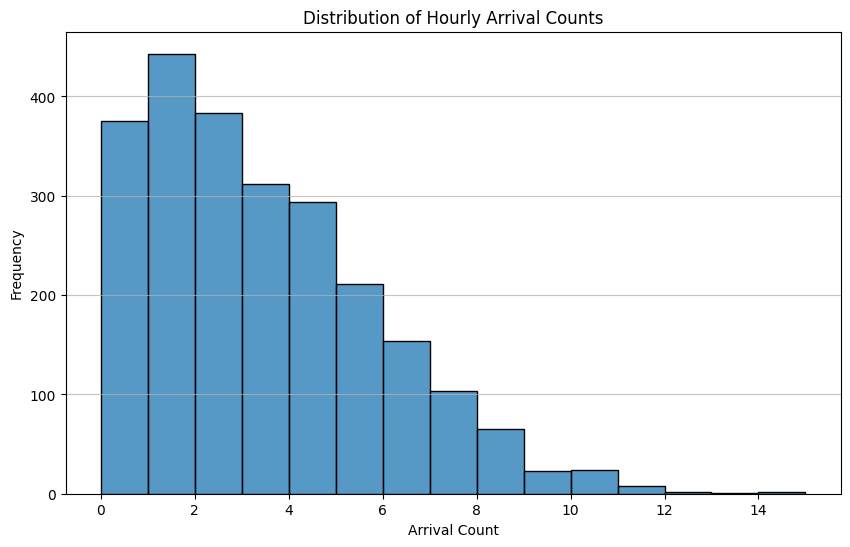

Hourly Arrival Statistics:
   Hour  mean  median       std  min  max
0  10am  2.48     2.0  1.493961    0    8
1  10pm  3.52     3.0  1.777980    0    9
2  11am  2.73     2.0  1.722431    0    8
3  11pm  3.02     3.0  1.687626    0    8
4  12am  2.20     2.0  1.483921    0    7
Hourly Arrival Statistics sorted by chronological hour:
    Hour  mean  median       std  min  max
4   12am  2.20     2.0  1.483921    0    7
6    1am  1.61     1.0  1.118215    0    4
8    2am  1.25     1.0  1.233988    0    5
10   3am  0.98     1.0  0.909878    0    4
12   4am  0.67     0.5  0.779212    0    3


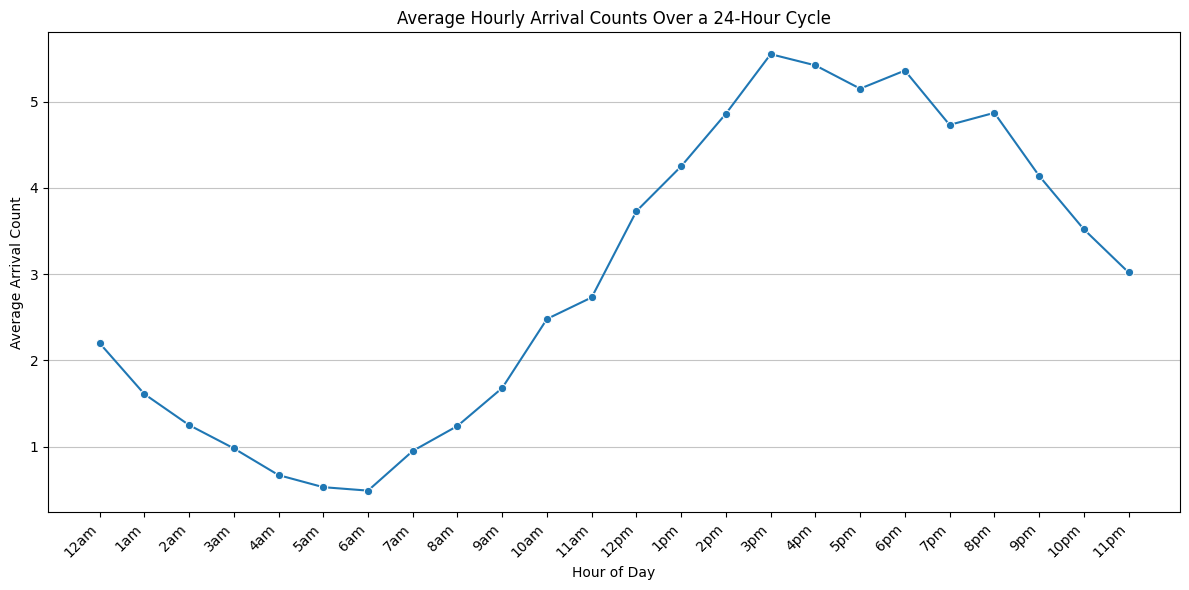

In [ ]:
#Arrivals Data csv

# Change the arrivals data into a wide format (days as rows, hours as columns)
arrivals_df = arrivals.rename(columns={'Unnamed: 0': 'Day'})
arrivals_long = pd.melt(arrivals_df, id_vars=['Day'], var_name='Hour', value_name='Arrival_Count')
print("First 5 rows of the reshaped arrivals_long DataFrame:")
print(arrivals_long.head())

# Examine the overall distribution across the hourly arrival counts across all of the days
mean_arrivals = arrivals_long['Arrival_Count'].mean()
median_arrivals = arrivals_long['Arrival_Count'].median()
std_arrivals = arrivals_long['Arrival_Count'].std()

print(f"Overall Arrival Distribution Statistics:")
print(f"  Mean: {mean_arrivals:.2f} arrivals per hour")
print(f"  Median: {median_arrivals:.2f} arrivals per hour")
print(f"  Standard Deviation: {std_arrivals:.2f} arrivals per hour")

# Visualize the overall pattern using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(arrivals_long['Arrival_Count'], bins=range(0, int(arrivals_long['Arrival_Count'].max()) + 2), kde=False)
plt.title('Distribution of Hourly Arrival Counts')
plt.xlabel('Arrival Count')
plt.ylabel('Frequency')
plt.xticks(range(0, int(arrivals_long['Arrival_Count'].max()) + 2, 2))
plt.grid(axis='y', alpha=0.75)
plt.show()

# Grouping the data by hour of data and the arival counts for each hour
hourly_arrival_stats = arrivals_long.groupby('Hour')['Arrival_Count'].agg(
    ['mean', 'median', 'std', 'min', 'max']
).reset_index()

print("Hourly Arrival Statistics:")
print(hourly_arrival_stats.head())

# Visualizing the average arival count per each hour of the day
hour_order = [
    '12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
    '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
    '8pm', '9pm', '10pm', '11pm'
]
hourly_arrival_stats['Hour'] = pd.Categorical(hourly_arrival_stats['Hour'], categories=hour_order, ordered=True)
hourly_arrival_stats = hourly_arrival_stats.sort_values('Hour')
print("Hourly Arrival Statistics sorted by chronological hour:")
print(hourly_arrival_stats.head())
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='mean', data=hourly_arrival_stats, marker='o')
plt.title('Average Hourly Arrival Counts Over a 24-Hour Cycle')
plt.xlabel('Hour of Day')
plt.ylabel('Average Arrival Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


Based on the overall arrival count with a mean of 2.98 and an std of 2.45 producing a variance of 6. Since the variance > mean we can assume overdispersion indicating a Negative Binomial distribution to be the most appropriate distribution to model the bed request arrivals. To further support this, the shape of the histogram is right skewed indicative of a Negative Binomial Distribution.

# **Treatment Times**

In [3]:
#Treatment Times csv
treatment_times = pd.read_csv('https://raw.githubusercontent.com/anjali-jv/Hospital-Wait-Times-Simulation/refs/heads/main/Data_TreatmentTimes.csv')
print(f"Loaded: {len(treatment_times)} treatment records")
print(f"\nSpecialties: {treatment_times['Specialty'].unique()}")
print(f"\nSample counts by specialty:")
print(treatment_times['Specialty'].value_counts())

print("\nFirst 10 rows:")
print(treatment_times.head(10))

Loaded: 18565 treatment records

Specialties: ['Ortho' 'Renal' 'Card' 'Respi' 'Gastro_Endo']

Sample counts by specialty:
Specialty
Card           4321
Respi          4321
Ortho          3425
Gastro_Endo    3254
Renal          3244
Name: count, dtype: int64

First 10 rows:
   ID  Treatment Time (Days)    Specialty
0   0               4.640229        Ortho
1   1               0.770322        Renal
2   2               1.911212         Card
3   3               4.199311        Respi
4   4               2.527663  Gastro_Endo
5   5               2.076513         Card
6   6               1.862886         Card
7   7               0.001040        Renal
8   8               0.213762        Respi
9   9               0.271861        Respi


In [5]:
def fit_distribution(data, specialty_name):
  '''
  This function aims to fit each of the specialties to Exponential, Lognormal, and Gamma
  to find the best fit. It returns a dictionary of the results and the raw data from the csv

  '''
  results = {
      'specialty': specialty_name,
      'n': len(data),
      'mean': np.mean(data),
      'std': np.std(data, ddof=1),
      'min': np.min(data),
      'max': np.max(data),
      'median': np.median(data)
  }
  print(f"\n{'_'*60}")
  print(f"{specialty_name}")
  print(f"{'_'*60}")
  print(f"Sample size: {results['n']}")
  print(f"Mean: {results['mean']:.3f} days")
  print(f"StdDev: {results['std']:.3f} days")
  print(f"Range: [{results['min']:.3f}, {results['max']:.3f}]")

  #exponential
  try:
      loc, scale = stats.expon.fit(data)
      exp_lambda = 1 / scale

      # KS test
      ks_stat, ks_pval = stats.kstest(data, 'expon', args=(loc, scale))

      results['exponential'] = {
          'loc': loc,
          'scale': scale,
          'lambda': exp_lambda,
          'ks_stat': ks_stat,
          'ks_pval': ks_pval
      }
  except Exception as e:
      results['exponential'] = None
      print(f"\n  Exponential: FAILED ({e})")

  #lognormal
  try:
      shape, loc, scale = stats.lognorm.fit(data, floc=0)

      #mu and sigma
      log_data = np.log(data)
      mu = np.mean(log_data)
      sigma = np.std(log_data, ddof=1)

      #KS test
      ks_stat, ks_pval = stats.kstest(data, 'lognorm', args=(shape, loc, scale))

      results['lognormal'] = {
          'shape': shape,
          'loc': loc,
          'scale': scale,
          'mu': mu,
          'sigma': sigma,
          'ks_stat': ks_stat,
          'ks_pval': ks_pval
      }
  except Exception as e:
      results['lognormal'] = None
      print(f"\n  Lognormal: FAILED ({e})")

  #gamma
  try:
      shape, loc, scale = stats.gamma.fit(data, floc=0)
      rate = 1 / scale

      # KS test
      ks_stat, ks_pval = stats.kstest(data, 'gamma', args=(shape, loc, scale))

      results['gamma'] = {
          'shape': shape,
          'loc': loc,
          'scale': scale,
          'rate': rate,
          'ks_stat': ks_stat,
          'ks_pval': ks_pval
      }
  except Exception as e:
      results['gamma'] = None
      print(f"\n  Gamma: FAILED ({e})")

  #best fit determination
  best_dist = None
  best_pval = 0
  for dist_name in ['exponential', 'lognormal', 'gamma']:
      if results.get(dist_name) and results[dist_name]['ks_pval'] > best_pval:
          best_pval = results[dist_name]['ks_pval']
          best_dist = dist_name

  results['best_fit'] = best_dist

  #printing only best fit results
  print(f"\nBest Fit: {best_dist} (p-value = {best_pval:.4f})")

  if best_dist == 'exponential' and results['exponential']:
    params = results['exponential']
    print(f"Parameters:")
    print(f" lambda (rate) = {params['lambda']:.4f}")
    print(f" scale (mean) = {params['scale']:.4f} days")
    #what to write in simio
    print(f" Simio: Random.Exponential({params['scale']:.4f})")
  elif best_dist == 'lognormal' and results['lognormal']:
    params = results['lognormal']
    print(f"Parameters:")
    print(f" mu = {params['mu']:.4f}")
    print(f" sigma = {params['sigma']:.4f}")
    #what to write in simio
    print(f" Simio: Random.Lognormal({params['mu']:.4f}, {params['sigma']:.4f})")
  elif best_dist == 'gamma' and results['gamma']:
    params = results['gamma']
    print(f"Parameters:")
    print(f" shape = {params['shape']:.4f}")
    print(f" scale = {params['scale']:.4f}")
    print(f" rate = {params['rate']:.4f}")
    #what to write in simio
    print(f" Simio(shap, scale): Random.Gamma({params['shape']:.4f}, {params['scale']:.4f})")
    print(f" Simio(shape, rate): Random.Gamma({params['shape']:.4f}, {params['rate']:.4f})")

  return results, data

In [6]:
#Testing for each Speacialty
all_specialty_results = {}

# Get unique specialties
specialties = treatment_times['Specialty'].unique()

print("Treatment Time Analysis of Best Fit Distribution")
print("*"*60)

# Analyze each specialty
for specialty in specialties:
    specialty_data = treatment_times[treatment_times['Specialty'] == specialty]
    times = specialty_data['Treatment Time (Days)'].values

    results, data = fit_distribution(times, specialty)
    all_specialty_results[specialty] = {
        'results': results,
        'data': data
    }

Treatment Time Analysis of Best Fit Distribution
************************************************************

____________________________________________________________
Ortho
____________________________________________________________
Sample size: 3425
Mean: 5.491 days
StdDev: 5.492 days
Range: [0.000, 52.501]

Best Fit: gamma (p-value = 0.9455)
Parameters:
 shape = 1.0147
 scale = 5.4112
 rate = 0.1848
 Simio(shap, scale): Random.Gamma(1.0147, 5.4112)
 Simio(shape, rate): Random.Gamma(1.0147, 0.1848)

____________________________________________________________
Renal
____________________________________________________________
Sample size: 3244
Mean: 4.823 days
StdDev: 6.828 days
Range: [0.000, 59.849]

Best Fit: gamma (p-value = 0.5833)
Parameters:
 shape = 0.5122
 scale = 9.4168
 rate = 0.1062
 Simio(shap, scale): Random.Gamma(0.5122, 9.4168)
 Simio(shape, rate): Random.Gamma(0.5122, 0.1062)

____________________________________________________________
Card
_____________________

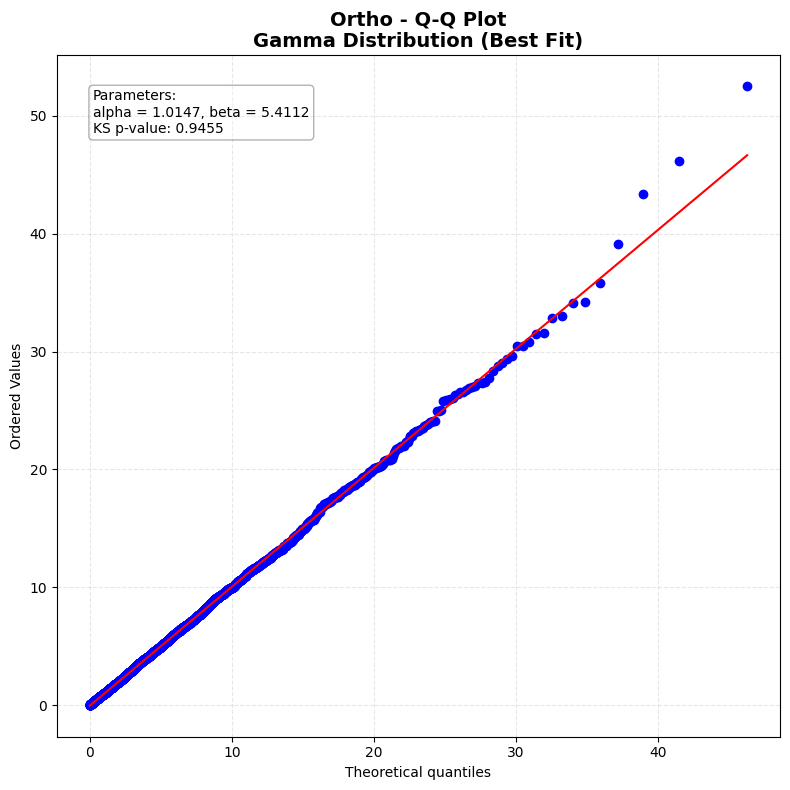

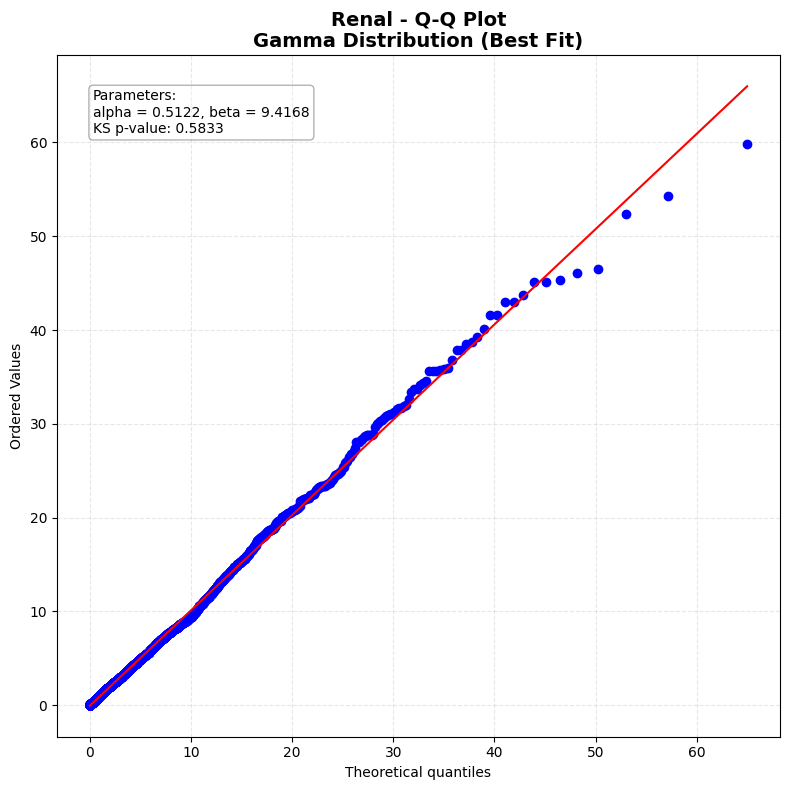

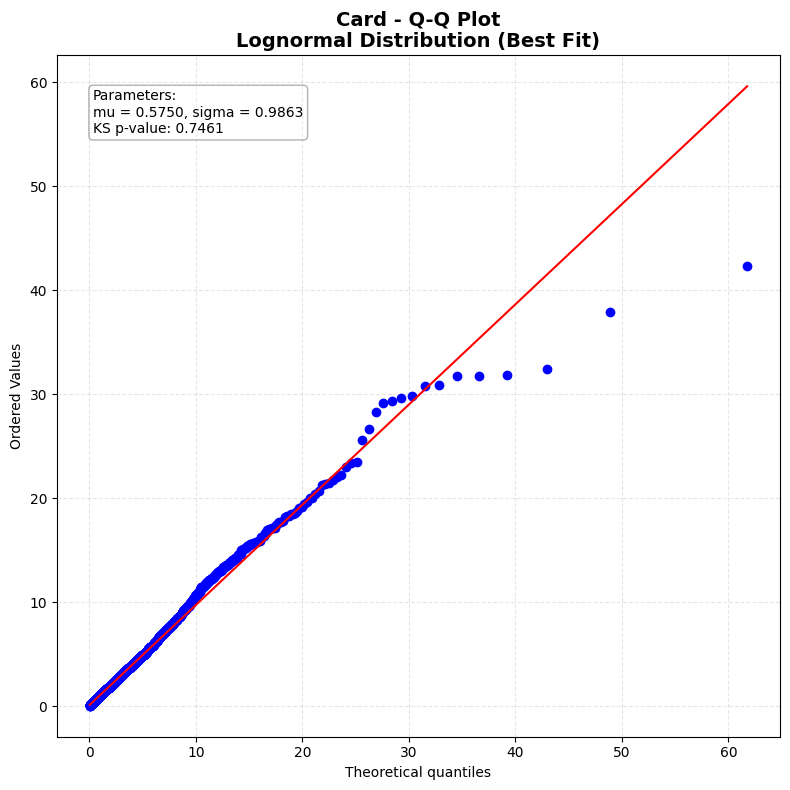

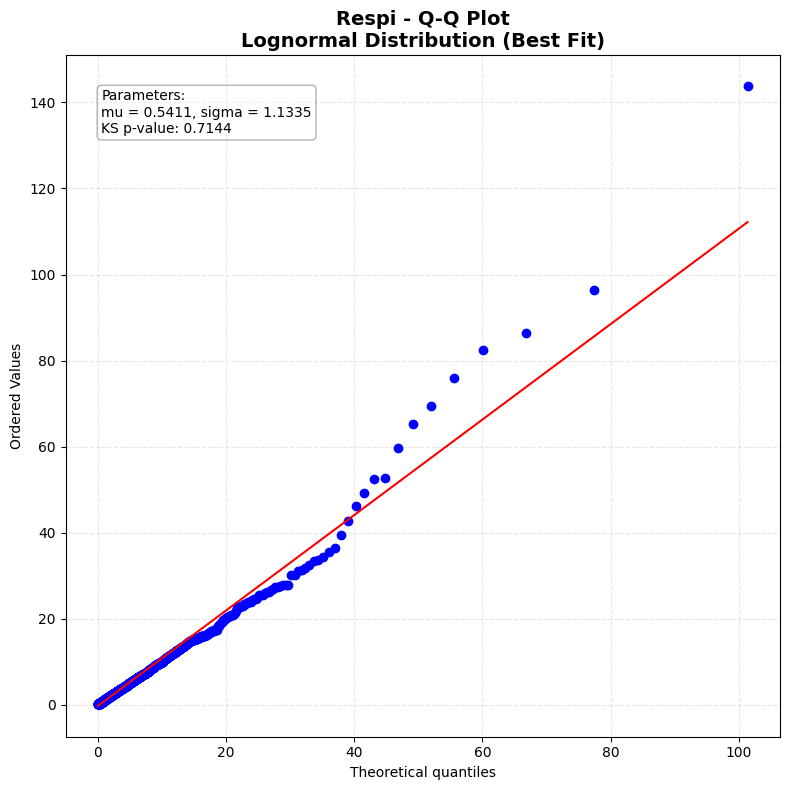

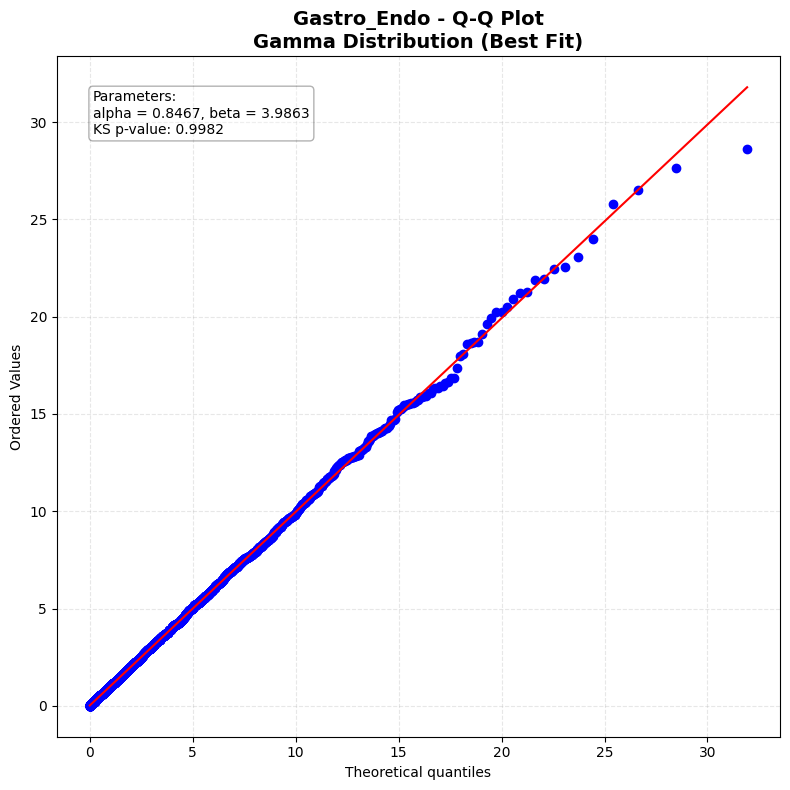

In [ ]:
#Creating Plots
#Creating Q-Q Plots
for specialty in all_specialty_results.keys():
  results = all_specialty_results[specialty]['results']
  data = all_specialty_results[specialty]['data']
  best_fit = results['best_fit']

  fig, ax = plt.subplots(figsize=(8, 8))

  # Q-Q plot for best fit only
  if best_fit == 'exponential':
    stats.probplot(data, dist='expon',
                  sparams=(results['exponential']['loc'],
                          results['exponential']['scale']),
                  plot=ax)
    params_text = f"lambda = {results['exponential']['lambda']:.4f}"

  elif best_fit == 'lognormal':
    stats.probplot(data, dist='lognorm',
                  sparams=(results['lognormal']['shape'],
                          results['lognormal']['loc'],
                          results['lognormal']['scale']),
                  plot=ax)
    params_text = f"mu = {results['lognormal']['mu']:.4f}, sigma = {results['lognormal']['sigma']:.4f}"

  elif best_fit == 'gamma':
    stats.probplot(data, dist='gamma',
                  sparams=(results['gamma']['shape'],
                          results['gamma']['loc'],
                          results['gamma']['scale']),
                  plot=ax)
    params_text = f"alpha = {results['gamma']['shape']:.4f}, beta = {results['gamma']['scale']:.4f}"

  ax.set_title(f'{specialty} - Q-Q Plot\n{best_fit.capitalize()} Distribution (Best Fit)',
            fontsize=14, fontweight='bold')
  ax.grid(alpha=0.3, linestyle='--')

  # Add parameter text
  ax.text(0.05, 0.95, f"Parameters:\n{params_text}\nKS p-value: {results[best_fit]['ks_pval']:.4f}",
         transform=ax.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.3))

  plt.tight_layout()
  plt.savefig(f'qq_{specialty}.png', dpi=300, bbox_inches='tight')
  plt.show()

### Analyzing the Q-Q Plot
Since the data for each of the different specialties falls on the line, we can confidently state that the theoretical distributions assigned to each specialty are correct